In [ ]:
import pandas as pd
import mplfinance as mpf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load raw LOBSTER message data
columns = ['time', 'type', 'order_id', 'size', 'price', 'direction']
lobster_df = pd.read_csv("data/aapl_lob.csv", header=None, names=columns)

# Keep only execution events: 4 (visible) and 5 (hidden)
executions = lobster_df[lobster_df['type'].isin([4, 5])].copy()

# Convert price from int to float (LOBSTER encodes prices as int * 10,000)
executions['price'] = executions['price'] / 10000

# Compute dollar value per trade
executions['dollar_value'] = executions['price'] * executions['size']

# Reset index
executions.reset_index(drop=True, inplace=True)

# Optional: convert time to readable format (seconds since midnight)
executions['time_seconds'] = executions['time']
executions['time'] = pd.to_datetime(executions['time'], unit='s', origin='2022-01-01')  # or any dummy base date


In [84]:
def build_tick_bars(df, threshold=100):
    bars = []
    for i in range(0, len(df), threshold):
        chunk = df.iloc[i:i+threshold]
        if not chunk.empty:
            bar = {
                'open_time': chunk['time'].iloc[0],
                'close_time': chunk['time'].iloc[-1],
                'open': chunk['price'].iloc[0],
                'high': chunk['price'].max(),
                'low': chunk['price'].min(),
                'close': chunk['price'].iloc[-1],
                'volume': chunk['size'].sum(),
                'dollar_value': chunk['dollar_value'].sum()
            }
            bars.append(bar)
    return pd.DataFrame(bars)


In [85]:
def build_volume_bars(df, threshold=10000):
    bars = []
    cum_vol = 0
    start_idx = 0

    for idx, row in df.iterrows():
        cum_vol += row['size']
        if cum_vol >= threshold:
            chunk = df.iloc[start_idx:idx+1]
            bar = {
                'open_time': chunk['time'].iloc[0],
                'close_time': chunk['time'].iloc[-1],
                'open': chunk['price'].iloc[0],
                'high': chunk['price'].max(),
                'low': chunk['price'].min(),
                'close': chunk['price'].iloc[-1],
                'volume': chunk['size'].sum(),
                'dollar_value': chunk['dollar_value'].sum()
            }
            bars.append(bar)
            start_idx = idx + 1
            cum_vol = 0
    return pd.DataFrame(bars)


In [86]:
def build_dollar_bars(df, threshold=1000000):
    bars = []
    cum_dollar = 0
    start_idx = 0

    for idx, row in df.iterrows():
        cum_dollar += row['dollar_value']
        if cum_dollar >= threshold:
            chunk = df.iloc[start_idx:idx+1]
            bar = {
                'open_time': chunk['time'].iloc[0],
                'close_time': chunk['time'].iloc[-1],
                'open': chunk['price'].iloc[0],
                'high': chunk['price'].max(),
                'low': chunk['price'].min(),
                'close': chunk['price'].iloc[-1],
                'volume': chunk['size'].sum(),
                'dollar_value': chunk['dollar_value'].sum()
            }
            bars.append(bar)
            start_idx = idx + 1
            cum_dollar = 0
    return pd.DataFrame(bars)


In [87]:
def build_time_bars(df, time_interval_seconds=300):  # Default 5 minutes
    """
    Build time bars from LOBSTER execution data
    
    Parameters:
    df: DataFrame with execution data (must have 'time' column)
    time_interval_seconds: Time interval in seconds for each bar
    
    Returns:
    DataFrame with OHLCV time bars
    """
    bars = []
    
    if df.empty:
        return pd.DataFrame()
    
    # Sort by time to ensure proper ordering
    df_sorted = df.sort_values('time').copy()
    
    # Get the start and end times
    start_time = df_sorted['time'].iloc[0]
    end_time = df_sorted['time'].iloc[-1]
    
    # Create time bins
    current_time = start_time
    
    while current_time < end_time:
        next_time = current_time + pd.Timedelta(seconds=time_interval_seconds)
        
        # Get data for this time window
        mask = (df_sorted['time'] >= current_time) & (df_sorted['time'] < next_time)
        chunk = df_sorted[mask]
        
        if not chunk.empty:
            bar = {
                'open_time': chunk['time'].iloc[0],
                'close_time': chunk['time'].iloc[-1],
                'open': chunk['price'].iloc[0],
                'high': chunk['price'].max(),
                'low': chunk['price'].min(),
                'close': chunk['price'].iloc[-1],
                'volume': chunk['size'].sum(),
                'dollar_value': chunk['dollar_value'].sum()
            }
            bars.append(bar)
        
        current_time = next_time
    
    return pd.DataFrame(bars)

In [88]:
tick_bars = build_tick_bars(executions, threshold=500)
volume_bars = build_volume_bars(executions, threshold=100000)
dollar_bars = build_dollar_bars(executions, threshold=10000000)
time_bars = build_time_bars(executions, time_interval_seconds=300) 

In [89]:
print("Time bars:", len(time_bars))
print("Tick bars:", len(tick_bars))
print("Volume bars:", len(volume_bars))
print("Dollar bars:", len(dollar_bars))


Time bars: 78
Tick bars: 70
Volume bars: 28
Dollar bars: 165


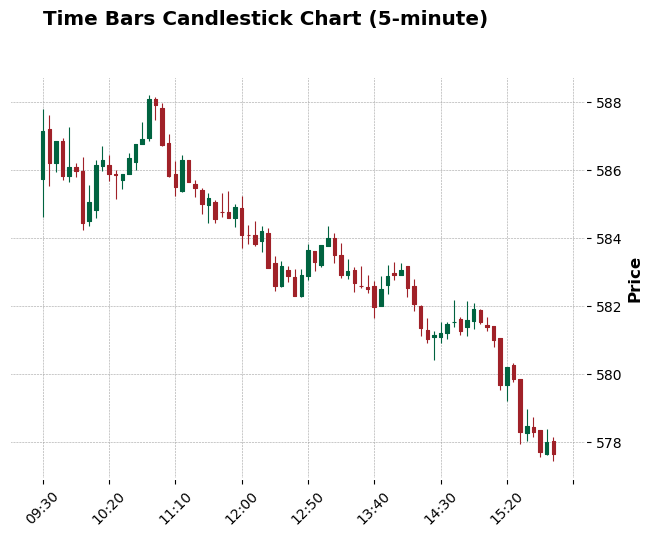

In [90]:
# Time bars chart
time_bars_mpf = time_bars.copy()
time_bars_mpf.rename(columns={'open_time': 'datetime'}, inplace=True)
time_bars_mpf.set_index('datetime', inplace=True)

ohlc_time = time_bars_mpf[['open', 'high', 'low', 'close']]

mpf.plot(ohlc_time, type='candle', style='charles', title="Time Bars Candlestick Chart (5-minute)", ylabel="Price")

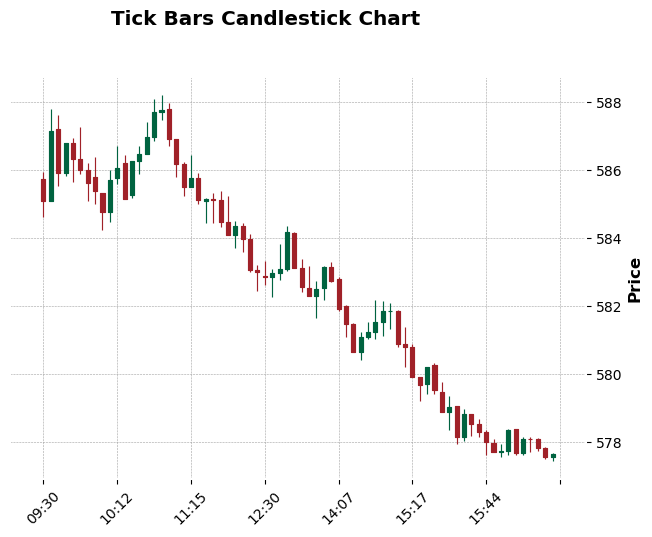

In [91]:
import mplfinance as mpf

tick_bars_mpf = tick_bars.copy()
tick_bars_mpf.rename(columns={'open_time': 'datetime'}, inplace=True)
tick_bars_mpf.set_index('datetime', inplace=True)

ohlc = tick_bars_mpf[['open', 'high', 'low', 'close']]

mpf.plot(ohlc, type='candle', style='charles', title="Tick Bars Candlestick Chart", ylabel="Price")



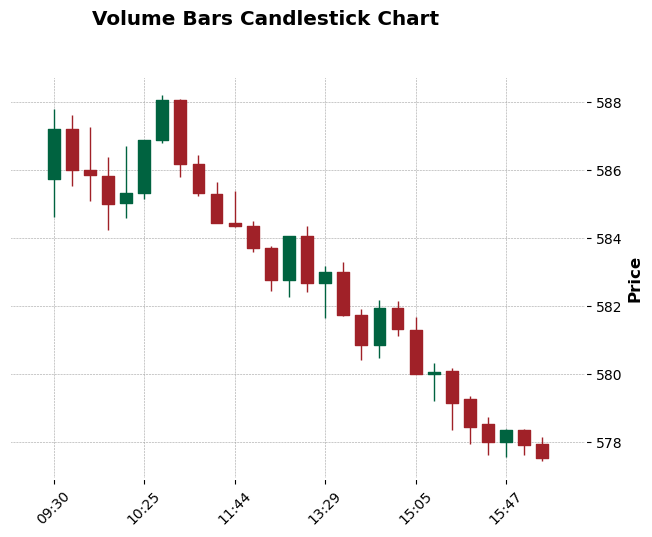

In [92]:
volume_bars_mpf = volume_bars.copy()
volume_bars_mpf.rename(columns={'open_time': 'datetime'}, inplace=True)
volume_bars_mpf.set_index('datetime', inplace=True)

ohlc_volume = volume_bars_mpf[['open', 'high', 'low', 'close']]

mpf.plot(ohlc_volume, type='candle', style='charles', title="Volume Bars Candlestick Chart", ylabel="Price")


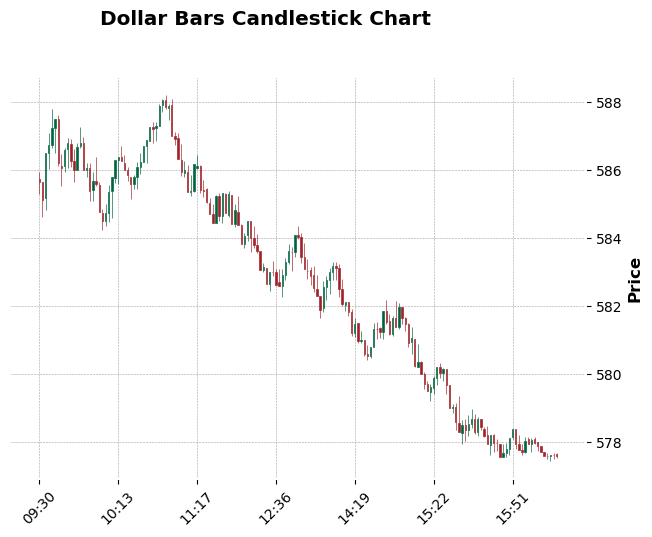

In [93]:
dollar_bars_mpf = dollar_bars.copy()
dollar_bars_mpf.rename(columns={'open_time': 'datetime'}, inplace=True)
dollar_bars_mpf.set_index('datetime', inplace=True)

ohlc_dollar = dollar_bars_mpf[['open', 'high', 'low', 'close']]

mpf.plot(ohlc_dollar, type='candle', style='charles', title="Dollar Bars Candlestick Chart", ylabel="Price")


In [ ]:
def analyze_bar_characteristics(time_bars, tick_bars, volume_bars, dollar_bars):
    """Analyze characteristics of different bar types"""

    bar_data = {
        'Time': time_bars,
        'Tick': tick_bars, 
        'Volume': volume_bars,
        'Dollar': dollar_bars
    }

    results = []

    for name, bars in bar_data.items():
        if not bars.empty:
            # Calculate duration in seconds
            bars = bars.copy()
            bars['duration'] = (bars['close_time'] - bars['open_time']).dt.total_seconds()
            bars['price_range'] = bars['high'] - bars['low']
            bars['volatility'] = bars['price_range'] / bars['open'] * 100  # Percentage
            bars['returns'] = (bars['close'] - bars['open']) / bars['open'] * 100
            
            result = {
                'Bar_Type': name,
                'Num_Bars': len(bars),
                'Avg_Duration_Sec': bars['duration'].mean(),
                'Avg_Volume': bars['volume'].mean(),
                'Avg_Dollar_Value': bars['dollar_value'].mean(),
                'Avg_Volatility_%': bars['volatility'].mean(),
                'Avg_Return_%': bars['returns'].mean(),
                'Std_Return_%': bars['returns'].std()
            }
            results.append(result)

    df = pd.DataFrame(results)
    print("=== BAR CHARACTERISTICS ANALYSIS ===")
    print(df.round(4))
    return df

In [95]:
def correlation_analysis(time_bars, tick_bars, volume_bars, dollar_bars):
    """Analyze correlations within each bar type between OHLCV features"""

    bar_data = {
        'Time': time_bars,
        'Tick': tick_bars,
        'Volume': volume_bars,
        'Dollar': dollar_bars
    }

    correlation_results = {}

    for name, bars in bar_data.items():
        if not bars.empty:
            # Create feature matrix for this bar type
            bars_analysis = bars.copy()
            
            # Add derived features
            bars_analysis['price_range'] = bars_analysis['high'] - bars_analysis['low']
            bars_analysis['returns'] = (bars_analysis['close'] - bars_analysis['open']) / bars_analysis['open']
            bars_analysis['volatility'] = bars_analysis['price_range'] / bars_analysis['open']
            
            # Calculate duration if time columns exist
            if 'open_time' in bars_analysis.columns and 'close_time' in bars_analysis.columns:
                bars_analysis['duration_sec'] = (bars_analysis['close_time'] - bars_analysis['open_time']).dt.total_seconds()
            
            # Select features for correlation
            features = ['open', 'high', 'low', 'close', 'volume', 'dollar_value', 
                        'price_range', 'returns', 'volatility']
            
            # Add duration if available
            if 'duration_sec' in bars_analysis.columns:
                features.append('duration_sec')
            
            # Calculate correlation matrix
            feature_data = bars_analysis[features]
            corr_matrix = feature_data.corr()
            
            correlation_results[name] = corr_matrix
            
            print(f"\n=== {name.upper()} BARS CORRELATION MATRIX ===")
            print(f"Features: {features}")
            print(corr_matrix.round(3))

    # Plot correlation heatmaps
    n_plots = len(correlation_results)
    if n_plots > 0:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for i, (name, corr_matrix) in enumerate(correlation_results.items()):
            if i < 4:  # Max 4 plots
                sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                            square=True, fmt='.2f', ax=axes[i],
                            cbar_kws={'shrink': 0.8})
                axes[i].set_title(f'{name} Bars - Feature Correlations')
                axes[i].tick_params(axis='x', rotation=45)
                axes[i].tick_params(axis='y', rotation=0)
        
        # Hide unused subplots
        for j in range(i+1, 4):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()

    return correlation_results

In [96]:
def statistical_comparison(time_bars, tick_bars, volume_bars, dollar_bars):
    """Statistical comparison of bar types"""
    
    bar_data = {
        'Time': time_bars,
        'Tick': tick_bars,
        'Volume': volume_bars, 
        'Dollar': dollar_bars
    }
    
    stats_results = []
    
    for name, bars in bar_data.items():
        if not bars.empty:
            bars = bars.copy()
            bars['returns'] = (bars['close'] - bars['open']) / bars['open'] * 100
            bars['volatility'] = (bars['high'] - bars['low']) / bars['open'] * 100
            
            stats = {
                'Bar_Type': name,
                'Mean_Return_%': bars['returns'].mean(),
                'Std_Return_%': bars['returns'].std(),
                'Min_Return_%': bars['returns'].min(),
                'Max_Return_%': bars['returns'].max(),
                'Mean_Volatility_%': bars['volatility'].mean(),
                'Sharpe_Ratio': bars['returns'].mean() / bars['returns'].std() if bars['returns'].std() != 0 else 0,
                'Skewness': bars['returns'].skew(),
                'Kurtosis': bars['returns'].kurtosis()
            }
            stats_results.append(stats)
    
    df = pd.DataFrame(stats_results)
    print("\n=== STATISTICAL COMPARISON ===")
    print(df.round(4))
    
    return df

In [97]:
def plot_bar_comparison(time_bars, tick_bars, volume_bars, dollar_bars):
    """Create comprehensive comparison plots"""
    
    bar_data = {
        'Time': time_bars,
        'Tick': tick_bars,
        'Volume': volume_bars,
        'Dollar': dollar_bars
    }
    
    # Remove empty datasets
    bar_data = {k: v for k, v in bar_data.items() if not v.empty}
    
    if not bar_data:
        print("No bar data available for plotting")
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Bar Type Comparison Analysis', fontsize=16, fontweight='bold')
    
    # 1. Number of bars
    methods = list(bar_data.keys())
    counts = [len(bars) for bars in bar_data.values()]
    
    axes[0,0].bar(methods, counts, color=['blue', 'orange', 'green', 'red'][:len(methods)])
    axes[0,0].set_title('Number of Bars by Method')
    axes[0,0].set_ylabel('Count')
    for i, v in enumerate(counts):
        axes[0,0].text(i, v + max(counts)*0.01, str(v), ha='center', va='bottom')
    
    # 2. Average volume per bar
    avg_volumes = [bars['volume'].mean() for bars in bar_data.values()]
    axes[0,1].bar(methods, avg_volumes, color=['blue', 'orange', 'green', 'red'][:len(methods)])
    axes[0,1].set_title('Average Volume per Bar')
    axes[0,1].set_ylabel('Volume')
    axes[0,1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # 3. Average dollar value per bar
    avg_dollars = [bars['dollar_value'].mean() for bars in bar_data.values()]
    axes[0,2].bar(methods, avg_dollars, color=['blue', 'orange', 'green', 'red'][:len(methods)])
    axes[0,2].set_title('Average Dollar Value per Bar')
    axes[0,2].set_ylabel('Dollar Value ($)')
    axes[0,2].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # 4. Return distributions
    for i, (name, bars) in enumerate(bar_data.items()):
        if not bars.empty:
            returns = (bars['close'] - bars['open']) / bars['open'] * 100
            axes[1,0].hist(returns, bins=30, alpha=0.7, label=name, 
                          color=['blue', 'orange', 'green', 'red'][i])
    
    axes[1,0].set_title('Return Distributions')
    axes[1,0].set_xlabel('Return (%)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].legend()
    
    # 5. Volatility comparison
    volatilities = []
    for bars in bar_data.values():
        if not bars.empty:
            vol = (bars['high'] - bars['low']) / bars['open'] * 100
            volatilities.append(vol.mean())
        else:
            volatilities.append(0)
    
    axes[1,1].bar(methods, volatilities, color=['blue', 'orange', 'green', 'red'][:len(methods)])
    axes[1,1].set_title('Average Volatility per Bar')
    axes[1,1].set_ylabel('Volatility (%)')
    
    # 6. Duration comparison (if time data available)
    durations = []
    for bars in bar_data.values():
        if not bars.empty and 'open_time' in bars.columns and 'close_time' in bars.columns:
            duration = (bars['close_time'] - bars['open_time']).dt.total_seconds().mean()
            durations.append(duration)
        else:
            durations.append(0)
    
    if any(d > 0 for d in durations):
        axes[1,2].bar(methods, durations, color=['blue', 'orange', 'green', 'red'][:len(methods)])
        axes[1,2].set_title('Average Duration per Bar')
        axes[1,2].set_ylabel('Duration (seconds)')
    else:
        axes[1,2].text(0.5, 0.5, 'Duration data\nnot available', 
                      ha='center', va='center', transform=axes[1,2].transAxes)
        axes[1,2].set_title('Average Duration per Bar')
    
    plt.tight_layout()
    plt.show()

=== BAR CHARACTERISTICS ANALYSIS ===
  Bar_Type  Num_Bars  Avg_Duration_Sec   Avg_Volume  Avg_Dollar_Value  \
0     Time        78          291.8718   36540.2564      2.129290e+07   
1     Tick        70          333.7631   40716.2857      2.372638e+07   
2   Volume        28          833.8111  100127.7500      5.835545e+07   
3   Dollar       165          140.9550   17261.3152      1.005865e+07   

   Avg_Volatility_%  Avg_Return_%  Std_Return_%  
0            0.1545       -0.0171        0.1027  
1            0.1640       -0.0210        0.1050  
2            0.2654       -0.0515        0.1597  
3            0.1056       -0.0082        0.0679  

=== TIME BARS CORRELATION MATRIX ===
Features: ['open', 'high', 'low', 'close', 'volume', 'dollar_value', 'price_range', 'returns', 'volatility', 'duration_sec']
               open   high    low  close  volume  dollar_value  price_range  \
open          1.000  0.989  0.984  0.971  -0.390        -0.383        0.227   
high          0.989  1.000

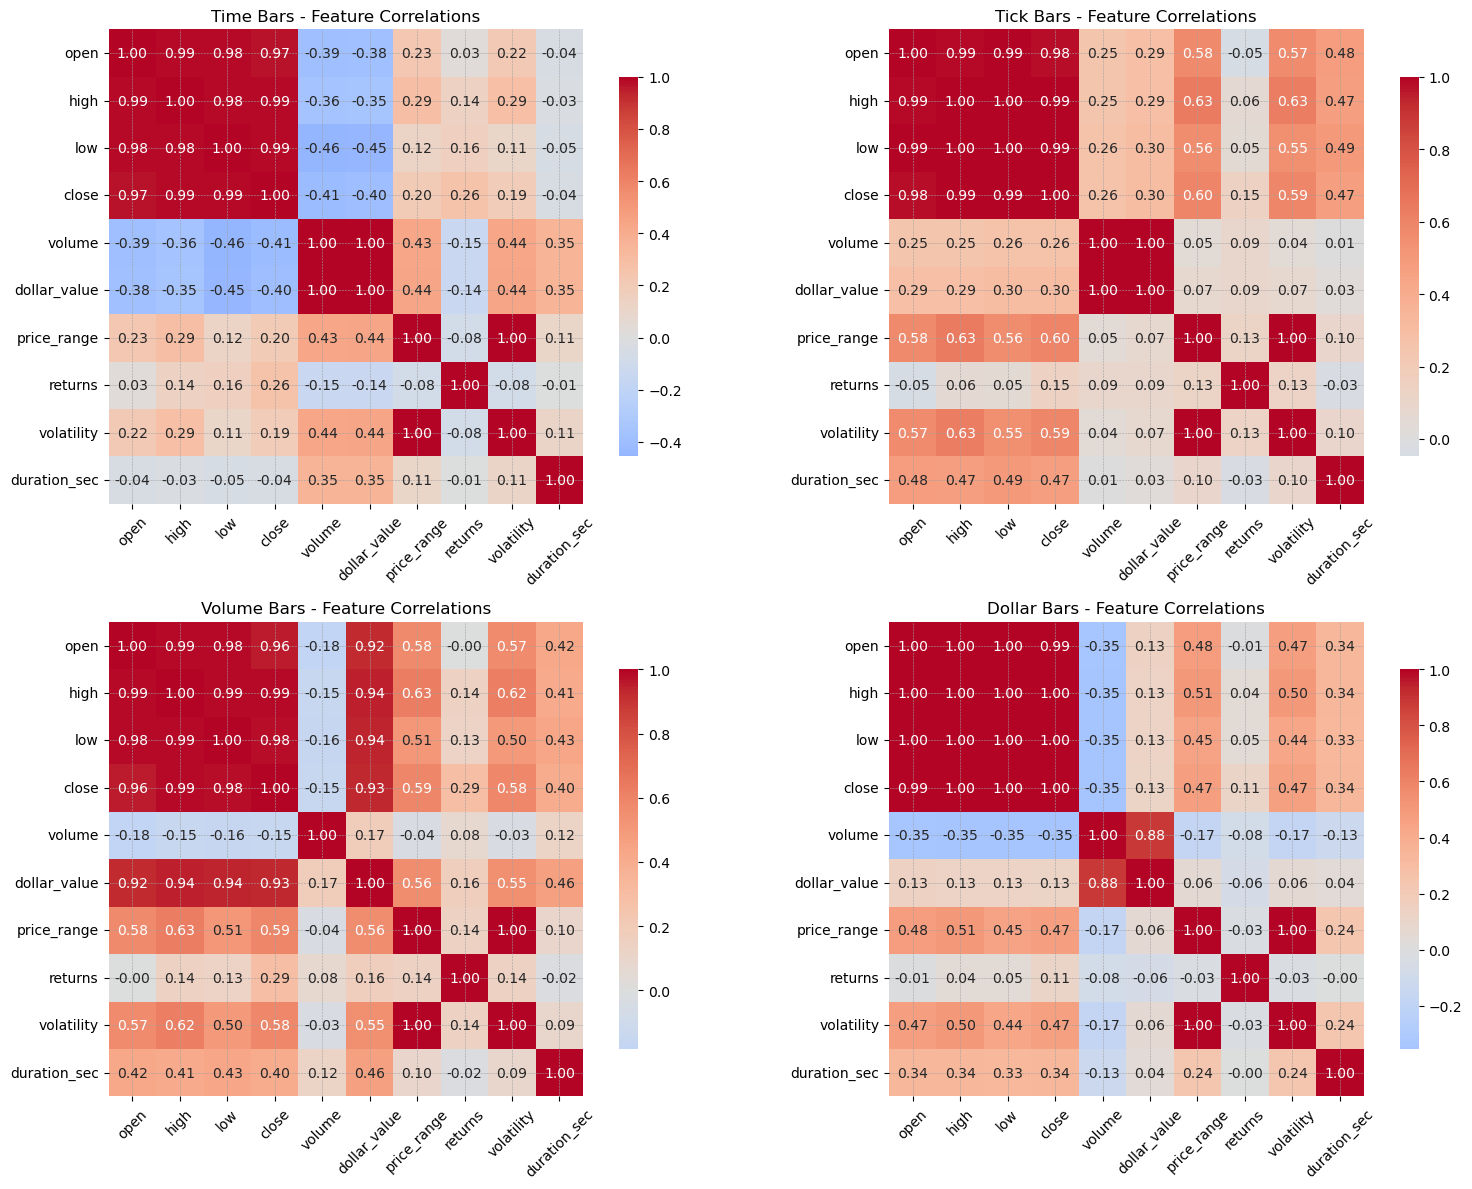


=== STATISTICAL COMPARISON ===
  Bar_Type  Mean_Return_%  Std_Return_%  Min_Return_%  Max_Return_%  \
0     Time        -0.0171        0.1027       -0.2708        0.2424   
1     Tick        -0.0210        0.1050       -0.2197        0.3538   
2   Volume        -0.0515        0.1597       -0.3180        0.2648   
3   Dollar        -0.0082        0.0679       -0.2196        0.2239   

   Mean_Volatility_%  Sharpe_Ratio  Skewness  Kurtosis  
0             0.1545       -0.1667   -0.0586    0.3273  
1             0.1640       -0.2000    0.7188    1.1157  
2             0.2654       -0.3226    0.6621   -0.4816  
3             0.1056       -0.1201    0.0497    0.3296  


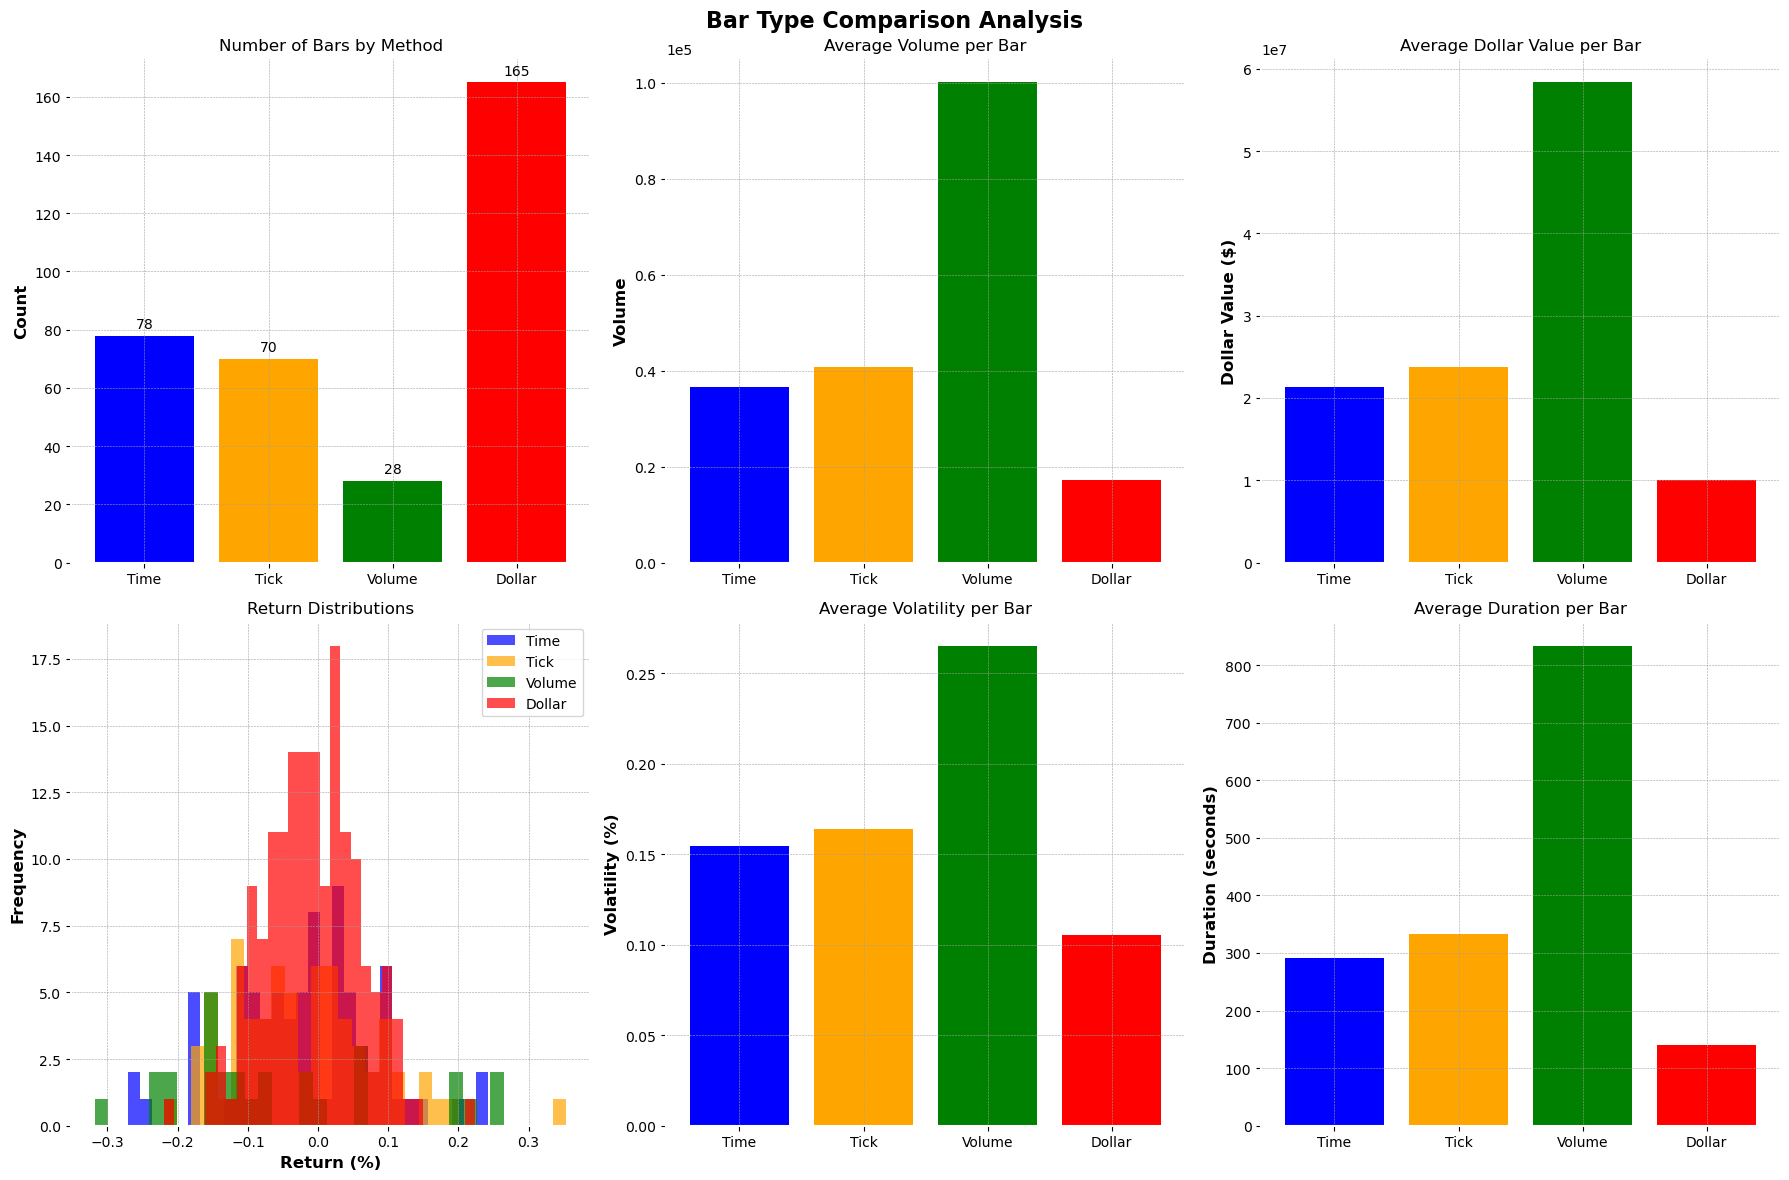

In [98]:


characteristics = analyze_bar_characteristics(time_bars, tick_bars, volume_bars, dollar_bars)
correlations = correlation_analysis(time_bars, tick_bars, volume_bars, dollar_bars)
stats = statistical_comparison(time_bars, tick_bars, volume_bars, dollar_bars)
plot_bar_comparison(time_bars, tick_bars, volume_bars, dollar_bars)